In [1]:
import sys 
if "." not in sys.path: 
    sys.path.append(".")

import source_world
import moth_brain_nengo
import moth_brain_nengo_new
import moth_brain_nengo_GIIC
import nengo
import pytry
import numpy as np

import matplotlib.pyplot as plt 
import scipy.ndimage.filters

In [2]:
class SimulationFail(Exception):
    pass
class SimulationSuccess(Exception):
    pass

In [3]:
pos_ls=[]

In [4]:


class parm(object):
    def __init__(self,moveable_source=True,x=0,y=-1):
        self.x=x
        self.y=y
        self.moveable_source=moveable_source
        self.heading=0

        self.min_x=-2
        self.max_x=2
        self.min_y=-2
        self.max_y=2
        self.source_x=0
        self.source_y=1
        self.distance_array=[]
        self.stop_distance=0.05
        self.max_time=20


p=parm(True)
model = nengo.Network()
with model:

    world = source_world.nengoSource(x=p.x, y=p.y, heading=p.heading+np.pi)
    if p.moveable_source:
        source=world.make_source_move()

    sensor=world.make_sensor() 
    rotation=world.make_movement() 
    pos = world.make_position()
    heading_and_vel = world.make_heading_and_velocity()


    brain = moth_brain_nengo_new.MothBrainNengo(noise=0, inhib=0, N=100)
    nengo.Connection(sensor[0], brain.inputR, transform=1, synapse=None)
    nengo.Connection(sensor[1], brain.inputL, transform=1, synapse=None)
    nengo.Connection(brain.turn, rotation, transform=10, synapse=None)

    def check_bounds(t):

        if world.x < p.min_x or world.x > p.max_x:
            raise SimulationFail()
        if world.y < p.min_y or world.y > p.max_y:
            raise SimulationFail()
        delta = [world.x - p.source_x, world.y - p.source_y]
        distance=np.linalg.norm(delta)
        p.distance_array.append(distance)
        if distance < p.stop_distance:
            raise SimulationSuccess()

    nengo.Node(check_bounds)

    p_pos = nengo.Probe(pos)
    p_heading = nengo.Probe(heading_and_vel[0])
    p_velocityx = nengo.Probe(heading_and_vel[1])
    p_velocityy = nengo.Probe(heading_and_vel[2])
    p_rotation = nengo.Probe(rotation,synapse=0.3)
    p_sensor = nengo.Probe(sensor)
    if p.moveable_source:
        p_source=nengo.Probe(source)

    input_left_probe = nengo.Probe(brain.inputL)
    input_right_probe = nengo.Probe(brain.inputR)

    PBN_left_probe = nengo.Probe(brain.PBN_l_slow, synapse=0.03)  # ,synapse=0.03
    PBN_right_probe = nengo.Probe(brain.PBN_r_slow, synapse=0.03)  # ,synapse=0.03

    FF_left_probe = nengo.Probe(brain.stateL, synapse=0.03)  # ,synapse=0.03)
    FF_right_probe = nengo.Probe(brain.stateR, synapse=0.03)  # ,synapse=0.03)

    GII_left_probe = nengo.Probe(brain.giia_l, synapse=0.03)
    GII_right_probe = nengo.Probe(brain.giia_r, synapse=0.03)

    turn_probe = nengo.Probe(brain.turn, synapse=0.03)  # )

sim = nengo.Simulator(model, progress_bar=False)
try:
    sim.run(p.max_time, progress_bar=True)
    success = False
except SimulationSuccess:
    success = True
except SimulationFail:

        success = False 




/Users/wangjiahui/Library/Python/3.7/lib/python/site-packages/nengo/cache.py:613: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

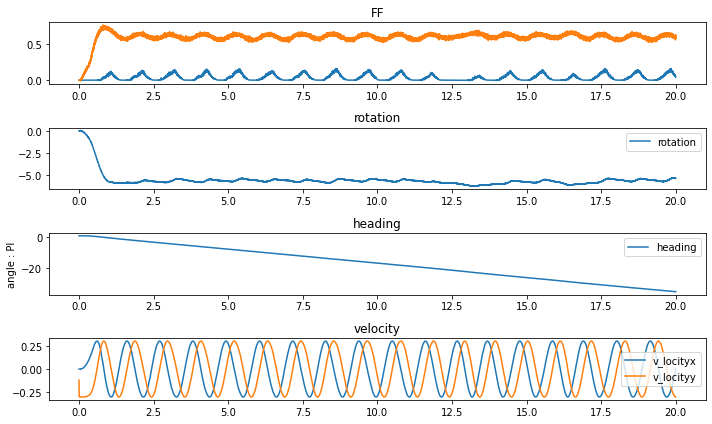

In [6]:

plt.figure(figsize=(10,6))
# plt.subplot(4, 1, 1)
# plt.plot(sim.trange(), sim.data[input_left_probe], label="left probe")
# plt.plot(sim.trange(), sim.data[input_right_probe], label="right_probe")
# plt.title("input")


# plt.legend()
# plt.subplot(8, 1, 2)
# plt.plot(sim.trange(), sim.data[PBN_left_probe], label="left probe")
# plt.plot(sim.trange(), sim.data[PBN_right_probe], label="right_probe")
# plt.title("PBN")

plt.subplot(4, 1, 1)
plt.plot(sim.trange(), sim.data[FF_left_probe][:, 0], label="left probe")
plt.plot(sim.trange(), sim.data[FF_right_probe][:, 0], label="right_probe")
plt.title("FF")

# plt.subplot(8, 1, 4)
# plt.plot(sim.trange(), sim.data[GII_left_probe], label="left probe")
# plt.plot(sim.trange(), sim.data[GII_right_probe], label="right_probe")

# plt.title("GIIA")
# plt.subplot(4, 1, 2)
# plt.plot(sim.trange(), sim.data[turn_probe][:, 0], label="turn probe")
# plt.ylim([-1.1, 1.1])
# plt.title("motor")


plt.subplot(4, 1, 2)
plt.plot(sim.trange(), sim.data[p_rotation], label="rotation")
plt.legend()
plt.title("rotation")


plt.subplot(4, 1, 3)
plt.plot(sim.trange(), sim.data[p_heading]/np.pi, label="heading")
plt.ylabel("angle : PI")
#plt.ylim([-3.15,3.15])
plt.legend()
plt.title("heading")


plt.subplot(4, 1, 4)
plt.plot(sim.trange(), sim.data[p_velocityx], label="v_locityx")
plt.plot(sim.trange(), sim.data[p_velocityy], label="v_locityy")
plt.legend()
plt.title("velocity")



plt.tight_layout()
plt.show()

        

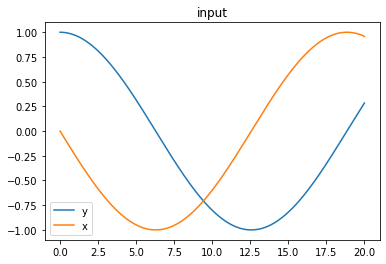

In [7]:
if p.moveable_source:
    plt.plot(sim.trange(), sim.data[p_source][:,1], label="y")
    plt.plot(sim.trange(), sim.data[p_source][:, 0], label="x")
    plt.legend()
    plt.title("input")

0 1


Text(0, 0.5, 'rotation rate (deg/sec)')

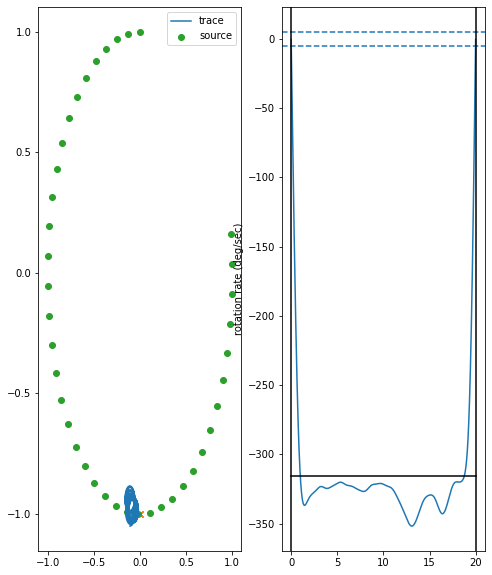

In [8]:

nx=500
dt=0.001
figure=plt.figure(figsize=(8,10))
ax = plt.subplot(1,2,1)


ax.scatter(p.x,p.y,marker="x")
xy = sim.data[p_pos]
ax.plot(xy[:,0], xy[:,1],label="trace")
xy = sim.data[p_pos]
ax.scatter([p.x], [p.y], marker='x')
print(p.source_x,p.source_y)
if p.moveable_source:
    ax.scatter(sim.data[p_source][:, 0][::nx],sim.data[p_source][:, 1][::nx],marker='o',label="source")
else:
    ax.scatter(p.source_x,p.source_y)
#ax.set_xlim(p.min_x, p.max_x)
#ax.set_ylim(p.min_y, p.max_y)
plt.legend()

ax2=plt.subplot(1,2,2)
heading = sim.data[p_heading][:,0]
heading_s = scipy.ndimage.filters.gaussian_filter(heading, sigma=0.5/dt)
rotation_rate = np.diff(heading_s) * 180 / np.pi / dt
turn_start = []
turn_end = []
turn_angle = []
turn_duration = []
turn_velocity = []

turning = (rotation_rate > 5) | (rotation_rate<-5)
for i in np.where(np.diff(turning.astype(int))==1)[0]:
    ends = np.where(turning[i+1:]==0)[0]
    if len(ends) == 0:
        j = len(turning)
    else:
        j = i+ends[0]

    if j > i + 500:  # must be 0.5s turn
        d_heading = (heading_s[j] - heading_s[i])*180 / np.pi
        if np.abs(d_heading) > 30:
            turn_start.append(i*dt)
            turn_end.append(j*dt)
            turn_angle.append(d_heading)
            turn_duration.append((j-i)*dt)
            turn_velocity.append(turn_angle[-1]/turn_duration[-1])
turn_duration = np.array(turn_duration)
turn_angle = np.array(turn_angle)
turn_velocity = np.array(turn_velocity)
turn_start = np.array(turn_start)
turn_end = np.array(turn_end)

heading = sim.data[p_heading][:,0]
heading_s = scipy.ndimage.filters.gaussian_filter(heading, sigma=0.5/dt)
rotation_rate = np.diff(heading_s) * 180 / np.pi / dt

t = np.arange(len(rotation_rate))*dt
ax2.plot(t, rotation_rate)
ax2.axhline(5, ls='--')
ax2.axhline(-5, ls='--')
for i in range(len(turn_start)):
    ax2.axvline(turn_start[i], c='k')
    ax2.axvline(turn_end[i], c='k')
    ax2.plot([turn_start[i], turn_end[i]], [turn_velocity[i], turn_velocity[i]], c='k')
ax2.set_ylabel('rotation rate (deg/sec)')